In [51]:
import pandas as pd
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg


### EDA 

#### Read data

In [25]:
df = pd.read_csv('train.csv')

In [26]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


#### Plot graphs

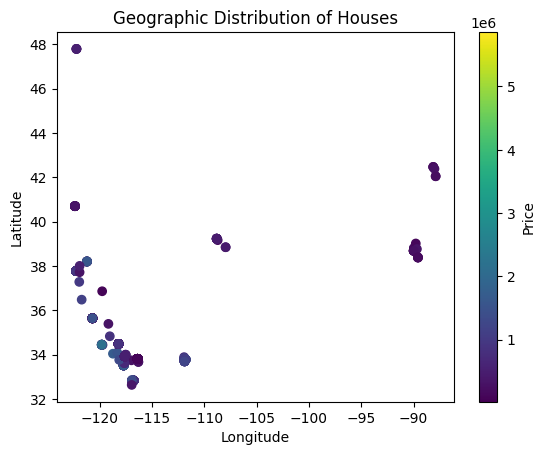

In [30]:
plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographic Distribution of Houses")
plt.show()


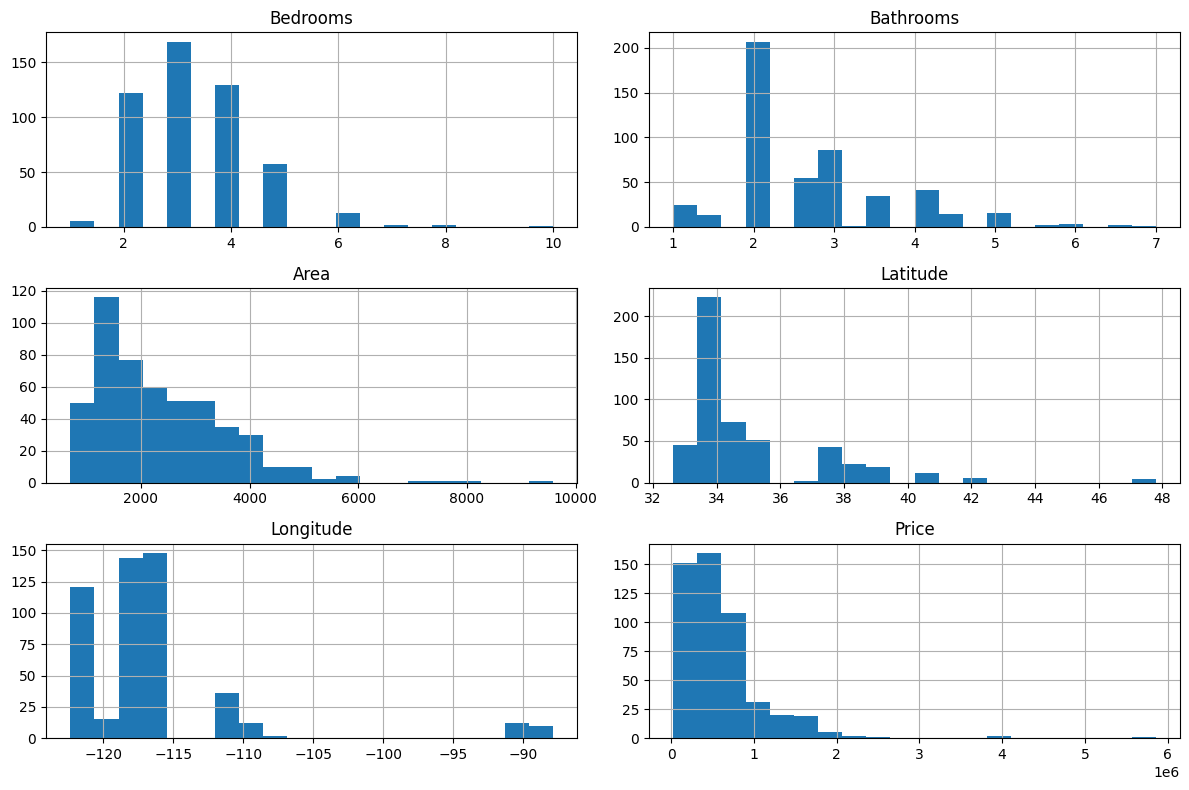

In [41]:
numeric_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "Price"]
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


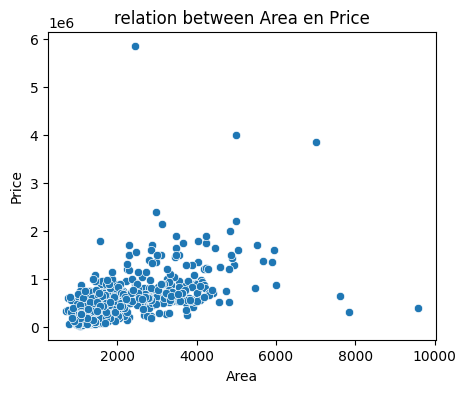

In [45]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="Area", y="Price", data=df)
plt.title("relation between Area en Price")
plt.show()


#### Correlations

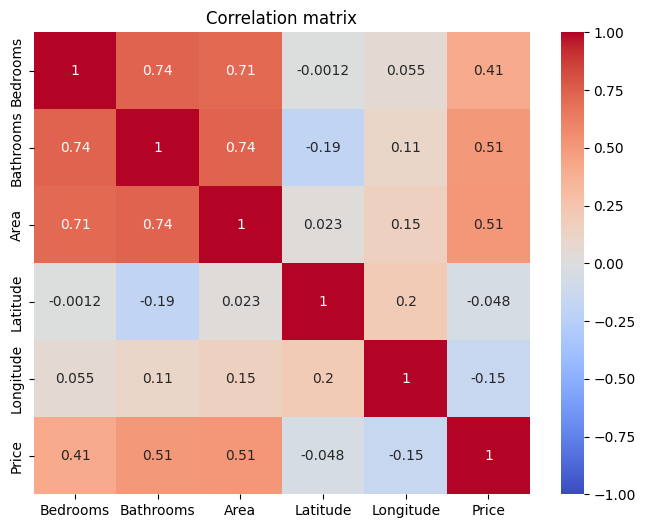

In [47]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


#### Outliers


In [50]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
print("Amount of outliers :", outliers.shape[0])


Amount of outliers : 23


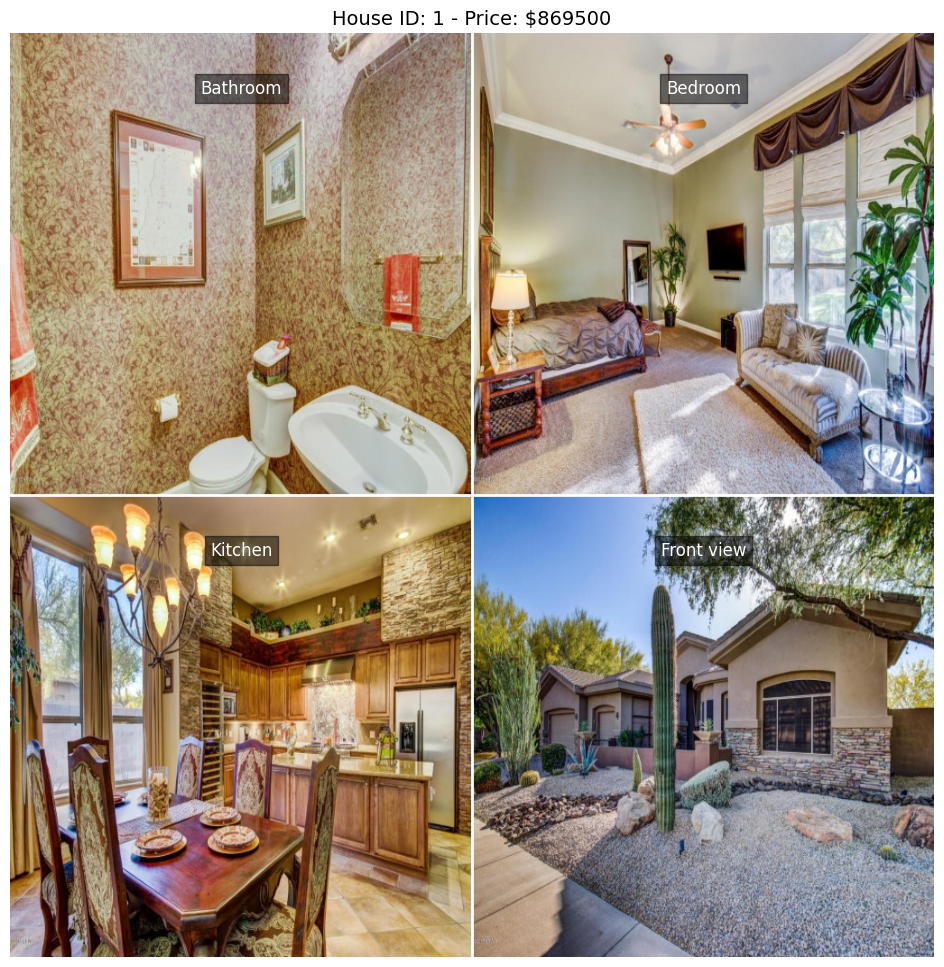

In [66]:
def display_house(house_id, df, folder='Train'):

    house_data = df.loc[df["House ID"] == house_id]
    if house_data.empty:
        print(f"House ID {house_id} Not Found")
        return
    
    num_bathrooms = house_data["Price"].values[0]
    filename = f"{house_id}.jpg"
    img_path = os.path.join(folder, filename)
    
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return
    
    img = mpimg.imread(img_path)
    height, width, _ = img.shape
    

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title(f"House ID: {house_id} - Price: ${num_bathrooms}", fontsize=14)
    plt.axis('off')
    
    plt.axvline(x=width/2, color='white', linewidth=2)
    plt.axhline(y=height/2, color='white', linewidth=2)

    plt.text(width*0.25, height*0.05, "Bathroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.05, "Bedroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.25, height*0.55, "Kitchen",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.55, "Front view",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))

    plt.show()


display_house(1, df, folder='Train')


In [ ]:
feature_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]
target_col = "Price"
X = df[feature_cols].values
y = df["Price"].values

house_ids = df["House ID"].values



In [67]:
def load_and_preprocess_image(house_id, folder='Train', img_size=(224, 224)):

    filename = f"{house_id}.jpg"
    path = os.path.join(folder, filename)
    
    img = cv2.imread(path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img


images = []
for hid in house_ids:
    img_array = load_and_preprocess_image(hid, folder='Train')
    images.append(img_array)

images = np.array(images)  # shape: (n, 224, 224, 3)


In [68]:
X_train, X_val, y_train, y_val, images_train, images_val = train_test_split(
    X, y, images, 
    test_size=0.2, 
    random_state=42
)


In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

image_input = layers.Input(shape=(224, 224, 3), name="image_input")
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)
cnn_output = layers.Dense(32, activation='relu')(x)

numeric_input = layers.Input(shape=(X_train_scaled.shape[1],), name="numeric_input")

y = layers.Dense(64, activation='relu')(numeric_input)
y = layers.Dropout(0.2)(y)
y = layers.Dense(32, activation='relu')(y)
mlp_output = layers.Dense(16, activation='relu')(y)

combined = layers.Concatenate()([cnn_output, mlp_output])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.2)(z)
z = layers.Dense(32, activation='relu')(z)
price_output = layers.Dense(1, activation='linear', name="price_output")(z)

model = models.Model(
    inputs=[image_input, numeric_input],
    outputs=price_output
)


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError()]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numeric_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │        384 │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │     40,992 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        528 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      3,136 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         33 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,098,804 (15.64 MB)

 Trainable params: 49,233 (192.32 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [76]:
history = model.fit(
    x=[images_train, X_train_scaled],
    y=y_train,
    validation_data=([images_val, X_val_scaled], y_val),
    epochs=50,
    batch_size=8
)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 874986143744.0000 - mean_absolute_error: 662072.8125 - val_loss: 473894682624.0000 - val_mean_absolute_error: 536156.3125
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 587489411072.0000 - mean_absolute_error: 598360.1875 - val_loss: 472881725440.0000 - val_mean_absolute_error: 535256.9375
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 715863162880.0000 - mean_absolute_error: 634695.6250 - val_loss: 461589446656.0000 - val_mean_absolute_error: 525772.5000
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 631442374656.0000 - mean_absolute_error: 593450.2500 - val_loss: 387944906752.0000 - val_mean_absolute_error: 463942.5625
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 469208268800.0000 - mean_absolute_error: 491158.1250 - val_loss: 181568225280.0000 - val_mean_absolute_error: 294937.0625
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 230422577152.0000 - mean_absolute_e

In [77]:
val_loss, val_mae = model.evaluate([images_val, X_val_scaled], y_val)
print("Val MSE:", val_loss)
print("Val MAE:", val_mae)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 79312486400.0000 - mean_absolute_error: 208586.7500
Val MSE: 76300337152.0
Val MAE: 206789.90625
